In [ ]:
# This is the implementation of the EncDec-AD model based on the paper "LSTM-based Encoder-Decoder for Multi-sensor Anomaly Detection". And a slight variantion "TimeNet" based on the paper "TimeNet: Pre-trained deep recurrent neural network for time series classiﬁcation", which has been shown that achives better performance in the time series anomaly detection scenario. The only difference is the second model feeds constants to its decoder as input.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import tensorflow as tf

# Definition of the EncDec-AD model

In [2]:
# decoder input: original time series value at last time step

class EncDecAD(object):
    def __init__(self,latent_dim,inputs):
        self.batch_num = inputs[0].get_shape().as_list()[0]
        self.input_dim = inputs[0].get_shape().as_list()[1]
        
        self.enc_cell = tf.nn.rnn_cell.LSTMCell(latent_dim)
        self.dec_cell = tf.nn.rnn_cell.LSTMCell(latent_dim)
        
        with tf.variable_scope('encoder'):
            self.enc_outputs, self.enc_state = tf.nn.static_rnn(self.enc_cell, inputs, 
                                                         dtype=tf.float32)
        with tf.variable_scope('decoder') as scope_dec:
            w = tf.Variable(tf.truncated_normal([latent_dim,self.input_dim],
                                               dtype=tf.float32),name="w")
            b = tf.Variable(tf.constant(0.1,shape=[self.input_dim],
                                               dtype=tf.float32),name="b")
            
            dec_inputs = [tf.zeros(tf.shape(inputs[0]),dtype=tf.float32)]+inputs[::-1][:-1]
            dec_outputs, dec_state = tf.nn.static_rnn(self.dec_cell, dec_inputs,
                                                     initial_state=self.enc_state,
                                                     dtype=tf.float32)
            dec_outputs = dec_outputs[::-1]
            dec_output = tf.transpose(tf.stack(dec_outputs),[1,0,2])
            w = tf.tile(tf.expand_dims(w,0),[self.batch_num,1,1])
            self.output = tf.matmul(dec_output,w)+b
            
        #Calculate loss
        self.input = tf.transpose(tf.stack(inputs),[1,0,2])
        self.loss = tf.reduce_sum(tf.square(self.input - self.output))
        
        #Optimization
        self.train = tf.train.AdamOptimizer(learning_rate=0.001).minimize(self.loss)

# Definition of the TimeNet model

In [2]:
class TimeNet(object):
    def __init__(self,latent_dim,inputs):
        self.batch_num = inputs[0].get_shape().as_list()[0]
        self.input_dim = inputs[0].get_shape().as_list()[1]
        
        self.enc_cell = tf.nn.rnn_cell.LSTMCell(latent_dim)
        self.dec_cell = tf.nn.rnn_cell.LSTMCell(latent_dim)
        
        with tf.variable_scope('encoder'):
            self.enc_outputs, self.enc_state = tf.nn.static_rnn(self.enc_cell, inputs, 
                                                         dtype=tf.float32)
        with tf.variable_scope('decoder') as scope_dec:
            w = tf.Variable(tf.truncated_normal([latent_dim,self.input_dim],
                                               dtype=tf.float32),name="w")
            b = tf.Variable(tf.constant(0.1,shape=[self.input_dim],
                                               dtype=tf.float32),name="b")
            
            dec_inputs = [tf.zeros(tf.shape(inputs[0]),dtype=tf.float32)
                                  for _ in range(len(inputs))]
            dec_outputs, dec_state = tf.nn.static_rnn(self.dec_cell, dec_inputs,
                                                     initial_state=self.enc_state,
                                                     dtype=tf.float32)
            dec_outputs = dec_outputs[::-1]
            dec_output = tf.transpose(tf.stack(dec_outputs),[1,0,2])
            w = tf.tile(tf.expand_dims(w,0),[self.batch_num,1,1])
            self.output = tf.matmul(dec_output,w)+b
            
        #Calculate loss
        self.input = tf.transpose(tf.stack(inputs),[1,0,2])
        self.loss = tf.reduce_mean(tf.square(self.input - self.output))
        
        #Optimization
        self.train = tf.train.AdamOptimizer().minimize(self.loss)

# Experiments

## Load dataset

In [3]:
# power demand dataset

%run Loaddata
from Loaddata import Loaddata

ld = Loaddata("power_demand")
dataset = ld.read()
dataset.shape


time_steps = 84
latent_dim = 1
n_epoch = 5000
batch_size = 17
input_dim = 1

# reshape the dataset to a list, each element with the shape [batch_size, time_steps, input_dim]
size = dataset.shape[0]//time_steps//batch_size
data_input = np.reshape(dataset[:size*batch_size*time_steps],(size,batch_size,time_steps,input_dim))
array = [t for t in data_input]
del dataset, data_input

# inputs placeholder
p_input = tf.placeholder(tf.float32, [batch_size, time_steps, input_dim])
p_inputs = [t for t in tf.split(p_input, time_steps, 1)]
p_inputs = [tf.squeeze(t, [1]) for t in tf.split(p_input, time_steps, 1)]



C:\Users\Bin\Desktop\Thesis\code\Loaddata.py:54: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  sub_power = sub_power.reshape(-1, 1)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [3]:
# space shuttle dataset

%run Loaddata
from Loaddata import Loaddata

ld = Loaddata("space_shuttle")
dataset = ld.read()

SUB_SEQUENCE_LENGTH = 500 # 1500/3
time_steps = SUB_SEQUENCE_LENGTH
latent_dim = 1
n_epoch = 100
batch_size = 14
input_dim = 1

# reshape the dataset to a list, each element with the shape [batch_size, time_steps, input_dim]
size = dataset.shape[0]//time_steps//batch_size
data_input = np.reshape(dataset[:size*batch_size*time_steps],(size,batch_size,time_steps,input_dim))
array = [t for t in data_input]
#del dataset, data_input

# inputs placeholder
p_input = tf.placeholder(tf.float32, [batch_size, time_steps, input_dim])
p_inputs = [t for t in tf.split(p_input, time_steps, 1)]
p_inputs = [tf.squeeze(t, [1]) for t in tf.split(p_input, time_steps, 1)]


C:\Users\Bin\Desktop\Thesis\code\Loaddata.py:71: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  sub_tek = sub_tek.reshape(-1, 1)


In [5]:
# EncDec-AD model

encdecad = EncDecAD(latent_dim, p_inputs)
saver = tf.train.Saver()
with tf.Session() as sess1:
    #saver.restore(sess, "/tmp/EncDecAD_model.ckpt")
    #print("Model restored.")
    sess1.run(tf.global_variables_initializer())
    for i in range(n_epoch):
        for a in array:
            loss_val, _ = sess1.run([encdecad.loss,encdecad.train],{p_input:a})
        print("Epoch %d: " % (i+1),loss_val)
    save_path = saver.save(sess1, "/tmp/EncDecAD_model_tek_50epochs.ckpt")
    print("Model saved in file: %s" % save_path) 
    
    #example
    input_, output_, encoded_, enc_state = sess1.run([encdecad.input, encdecad.output, 
                                                    encdecad.enc_outputs, encdecad.enc_state], {p_input:array[0]})
    embedding = enc_state[0]
    print("Example: ")
    print("embedding: ",embedding)
    print("input :", input_[0,:,:].flatten())
    print("output :", output_[0,:,:].flatten())

Epoch 1:  618.093
Epoch 2:  606.317
Epoch 3:  594.608
Epoch 4:  582.971
Epoch 5:  571.41
Epoch 6:  559.929
Epoch 7:  548.531
Epoch 8:  537.222
Epoch 9:  526.004
Epoch 10:  514.882
Epoch 11:  503.859
Epoch 12:  492.94
Epoch 13:  482.128
Epoch 14:  471.426
Epoch 15:  460.839
Epoch 16:  450.37
Epoch 17:  440.023
Epoch 18:  429.802
Epoch 19:  419.709
Epoch 20:  409.749
Epoch 21:  399.926
Epoch 22:  390.244
Epoch 23:  380.705
Epoch 24:  371.313
Epoch 25:  362.073
Epoch 26:  352.987
Epoch 27:  344.06
Epoch 28:  335.296
Epoch 29:  326.698
Epoch 30:  318.27
Epoch 31:  310.015
Epoch 32:  301.937
Epoch 33:  294.039
Epoch 34:  286.326
Epoch 35:  278.799
Epoch 36:  271.463
Epoch 37:  264.32
Epoch 38:  257.373
Epoch 39:  250.624
Epoch 40:  244.077
Epoch 41:  237.732
Epoch 42:  231.592
Epoch 43:  225.657
Epoch 44:  219.93
Epoch 45:  214.41
Epoch 46:  209.099
Epoch 47:  203.994
Epoch 48:  199.097
Epoch 49:  194.406
Epoch 50:  189.919
Epoch 51:  185.634
Epoch 52:  181.549
Epoch 53:  177.661
Epoch 54: 

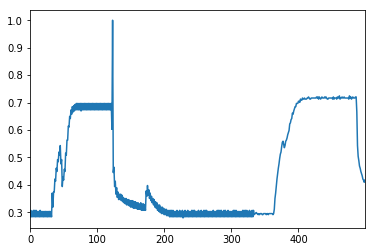

In [6]:
pd.Series(input_[0,:,:].flatten()).plot()

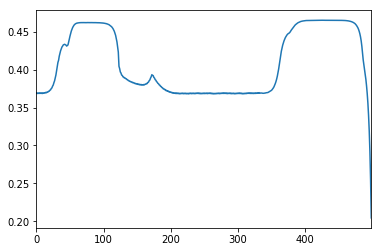

In [7]:
pd.Series(output_[0,:,:].flatten()).plot()

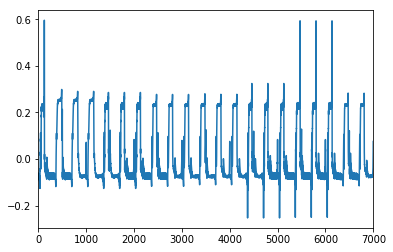

In [12]:
# Reconstruction error
(pd.Series(input_[:,:,:].flatten())-pd.Series(output_[:,:,:].flatten())).plot()

In [5]:
# TimeNet
timenet = TimeNet(latent_dim, p_inputs)
with tf.Session() as sess2:
    sess2.run(tf.global_variables_initializer())
    for i in range(n_epoch):
        for a in array:
            loss_val, _ = sess2.run([timenet.loss,timenet.train],{p_input:a})
        print("Epoch %d: " % (i+1),loss_val)
    #example
    input_, output_, encoded_, enc_state = sess2.run([timenet.input, timenet.output, 
                                                    timenet.enc_outputs, timenet.enc_state], {p_input:array[-1]})
   

Epoch 1:  0.12222
Epoch 2:  0.118857
Epoch 3:  0.115543
Epoch 4:  0.112282
Epoch 5:  0.109077
Epoch 6:  0.10593
Epoch 7:  0.102845
Epoch 8:  0.0998246
Epoch 9:  0.0968713
Epoch 10:  0.0939876
Epoch 11:  0.0911752
Epoch 12:  0.0884356
Epoch 13:  0.0857696
Epoch 14:  0.0831777
Epoch 15:  0.0806601
Epoch 16:  0.0782171
Epoch 17:  0.0758495
Epoch 18:  0.073558
Epoch 19:  0.0713443
Epoch 20:  0.06921
Epoch 21:  0.067157
Epoch 22:  0.065187
Epoch 23:  0.063302
Epoch 24:  0.0615036
Epoch 25:  0.0597935
Epoch 26:  0.058173
Epoch 27:  0.0566432
Epoch 28:  0.055205
Epoch 29:  0.0538587
Epoch 30:  0.0526043
Epoch 31:  0.0514414
Epoch 32:  0.0503689
Epoch 33:  0.0493854
Epoch 34:  0.0484887
Epoch 35:  0.047676
Epoch 36:  0.0469442
Epoch 37:  0.0462892
Epoch 38:  0.0457069
Epoch 39:  0.0451924
Epoch 40:  0.0447406
Epoch 41:  0.0443462
Epoch 42:  0.044004
Epoch 43:  0.0437085
Epoch 44:  0.0434546
Epoch 45:  0.0432375
Epoch 46:  0.0430525
Epoch 47:  0.0428958
Epoch 48:  0.0427635
Epoch 49:  0.0426524